# Medical Images Registeration

In this part, we will explore MR and CT Images Registeration


**Registeration method summary:**

Creating an instance of the registration framework requires selection of the following components:
   * Optimizer.
   * Similarity metric.
   * Interpolator.


## Registration Components 

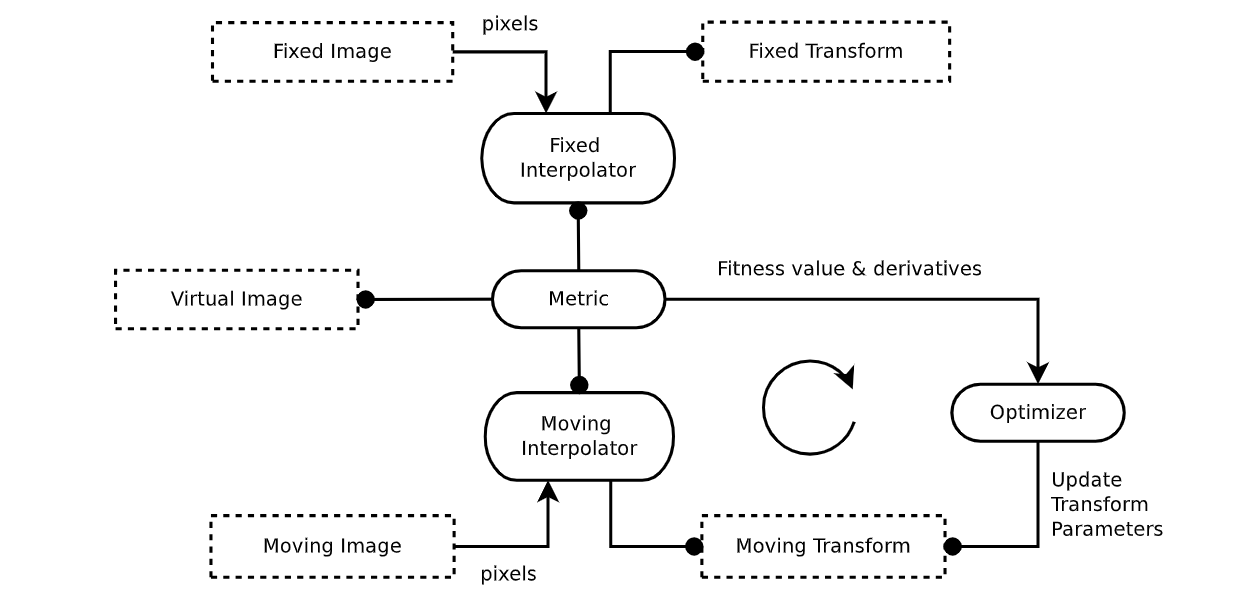

There are many options for creating an instance of the registration framework, all of which are configured in SimpleITK via methods of the <a href="https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageRegistrationMethod.html">ImageRegistrationMethod</a> class. This class encapsulates many of the components available in ITK for constructing a registration instance.

Currently, the available choices from the following groups of ITK components are:

### Optimizers

The SimpleITK registration framework supports several optimizer types via the SetOptimizerAsX() methods, these include:

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html">Nelder-Mead downhill simplex</a>, a.k.a. Amoeba.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1PowellOptimizerv4.html">Powell optimizer</a>.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1OnePlusOneEvolutionaryOptimizerv4.html">1+1 evolutionary optimizer</a>.
  </li>
  <li>
  Variations on gradient descent:
  <ul>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html">GradientDescent</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html">GradientDescentLineSearch</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html">RegularStepGradientDescent</a>
    </li>
  </ul>
  </li>
  <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html">ConjugateGradientLineSearch</a> 
  </li>
  <li>
  <a href="https://itk.org/Doxygen/html/classitk_1_1LBFGS2Optimizerv4.html">L-BFGS2</a> (Limited memory Broyden,  Fletcher,Goldfarb,Shannon)
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html">L-BFGS-B</a> (Limited memory Broyden,  Fletcher,Goldfarb,Shannon-Bound Constrained) - supports the use of simple constraints ($l\leq x \leq u$)  
  </li>
    
</ul>

 
### Similarity metrics

The SimpleITK registration framework supports several metric types via the SetMetricAsX() methods, these include:

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html">MeanSquares</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html">Demons</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html">Correlation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html">ANTSNeighborhoodCorrelation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html">JointHistogramMutualInformation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html">MattesMutualInformation</a>
  </li>
</ul>


### Interpolators

The SimpleITK registration framework supports several interpolators via the SetInterpolator() method, which receives one of
the <a href="https://simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5">following enumerations</a>:
<ul>
<li> sitkNearestNeighbor </li>
<li> sitkLinear </li>
<li> sitkBSpline </li>
<li> sitkGaussian </li>
<li> sitkHammingWindowedSinc </li>
<li> sitkCosineWindowedSinc </li>
<li> sitkWelchWindowedSinc </li>
<li> sitkLanczosWindowedSinc </li>
<li> sitkBlackmanWindowedSinc </li>
</ul>

Installing Libraries

In [3]:
!pip install SimpleITK matplotlib numpy ipympl 

In [ ]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata

%matplotlib ipympl
import gui
import registration_gui as rgui
import matplotlib.pyplot as plt
import numpy as np
import os

OUTPUT_DIR = "output"

## Read images

We first read the images, specifying the pixel type that is required for registration (Float32 or Float64) and look at them. In this notebook we use a CT and MR image from the same patient. These are part of the training data from the Retrospective Image Registration Evaluation (<a href="https://rire.insight-journal.org/">RIRE</a>) project.

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha


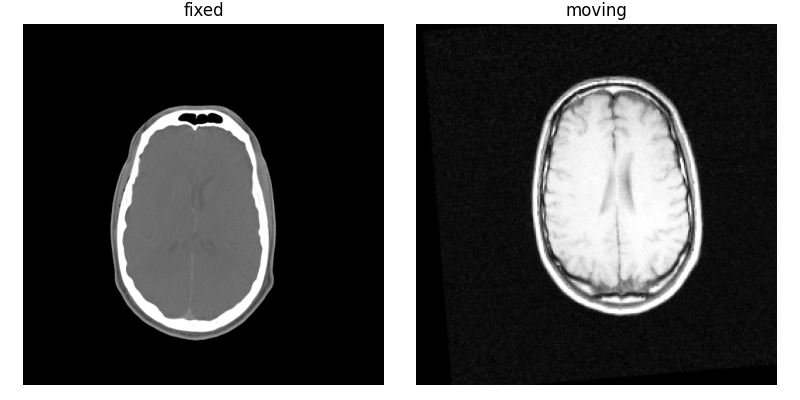

In [5]:
fixed_image = sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

ct_window_level = [835, 162]
mr_window_level = [1036, 520]

gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed", "moving"],
    figure_size=(8, 4),
    window_level_list=[ct_window_level, mr_window_level],
);

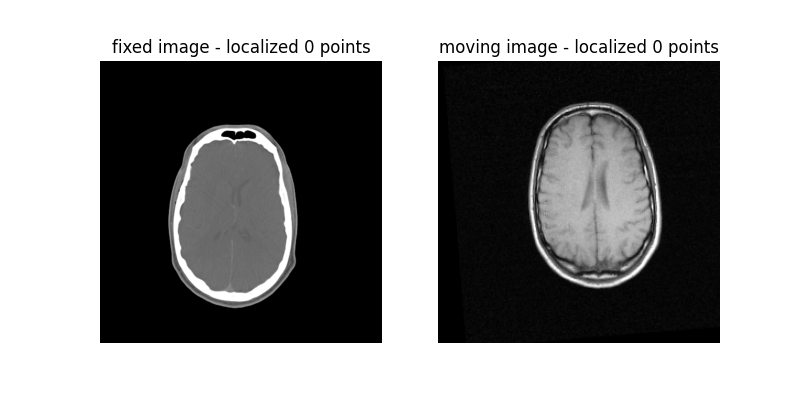

In [6]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=initial_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

In [7]:
registered_image = sitk.Resample(
    moving_image,             # The image to transform
    fixed_image,              # The reference image for alignment
    initial_transform,       # The composite transform
    sitk.sitkLinear,          # Interpolation method
    0.0,                      # Default pixel value for regions outside the image
    moving_image.GetPixelID() # Pixel type remains the same as the moving image
)

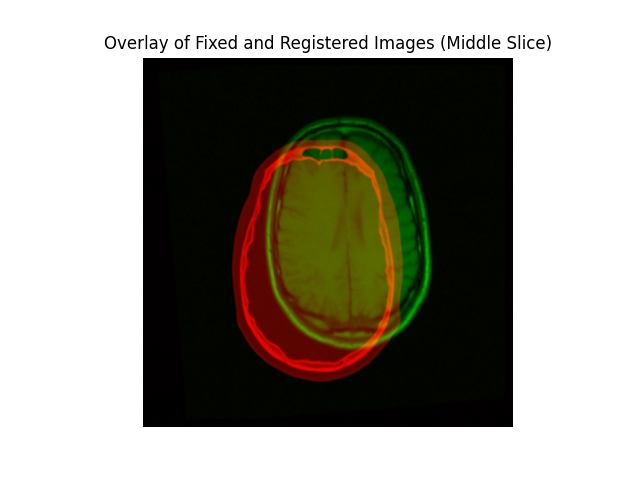

In [12]:
import numpy as np
import matplotlib.pyplot as plt
fixed_array = sitk.GetArrayViewFromImage(fixed_image)
registered_array = sitk.GetArrayViewFromImage(registered_image)

# Normalize images to [0, 1]
fixed_norm = (fixed_array - fixed_array.min()) / (fixed_array.max() - fixed_array.min())
registered_norm = (registered_array - registered_array.min()) / (registered_array.max() - registered_array.min())

middle_slice_index = fixed_norm.shape[0] // 2

# Extract the middle slice for both normalized arrays
fixed_slice = fixed_norm[middle_slice_index, :, :]
registered_slice = registered_norm[middle_slice_index, :, :]

# Create an RGB image for the middle slice
overlay = np.zeros((fixed_slice.shape[0], fixed_slice.shape[1], 3))
overlay[..., 0] = fixed_slice  # Red channel
overlay[..., 1] = registered_slice  # Green channel

# Display the overlay
plt.figure()  # Ensure a fresh plot
plt.imshow(overlay)
plt.title("Overlay of Fixed and Registered Images (Middle Slice)")
plt.axis("off")
plt.show()

In [14]:
resampled_moving_image = sitk.Resample(
    moving_image,  # The image to transform
    fixed_image,   # Reference image to match
    initial_transform,  # Use the initial transform (or identity)
    sitk.sitkLinear,     # Interpolation method
    0.0,                 # Default pixel value for out-of-bounds regions
    moving_image.GetPixelID()
)

In [15]:
difference_before = sitk.Abs(fixed_image - resampled_moving_image)
difference_after = sitk.Abs(fixed_image - registered_image)


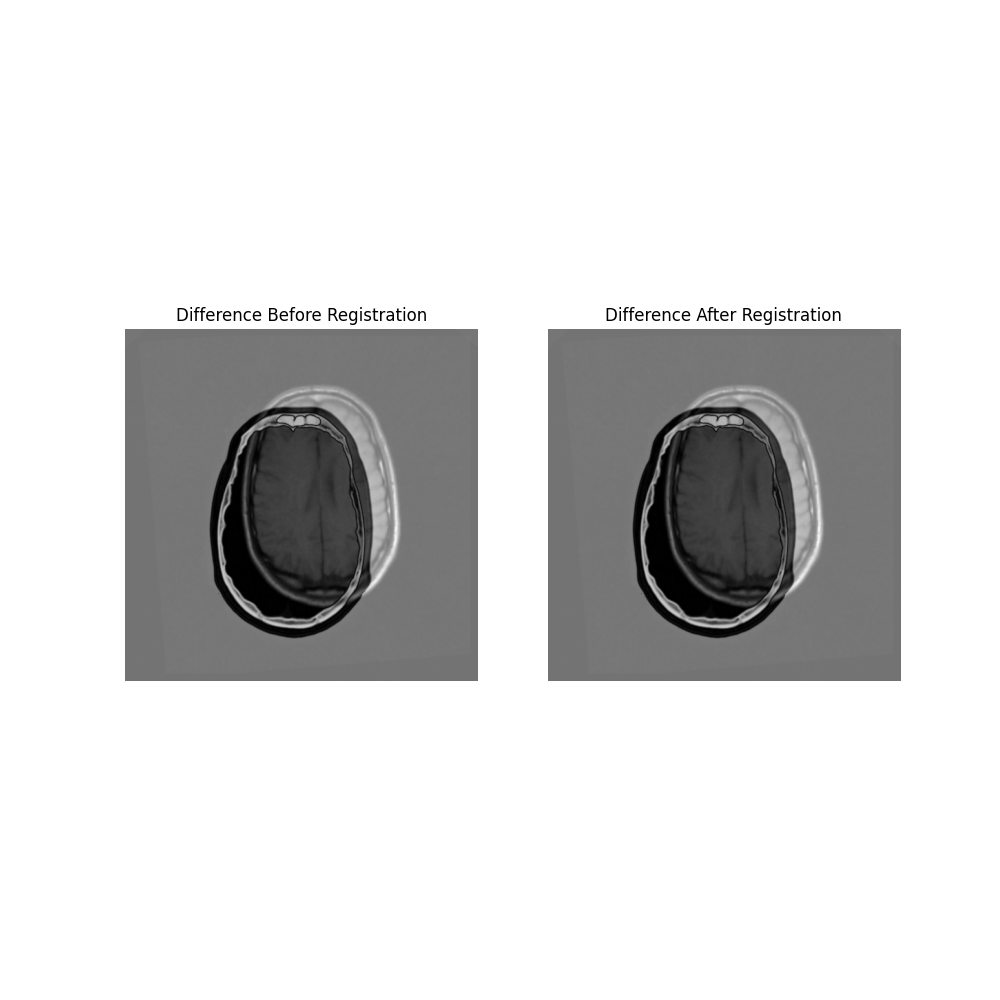

In [16]:
display_images_middle_slice(
    [difference_before, difference_after],
    ["Difference Before Registration", "Difference After Registration"]
)

## ITKv4 Coordinate Systems

Unlike the classical registration approach where the fixed and moving images are treated differently, the ITKv4 registration framework allows you to treat both images in the same manner. This is achieved by introducing a third coordinate system, the virtual image domain.

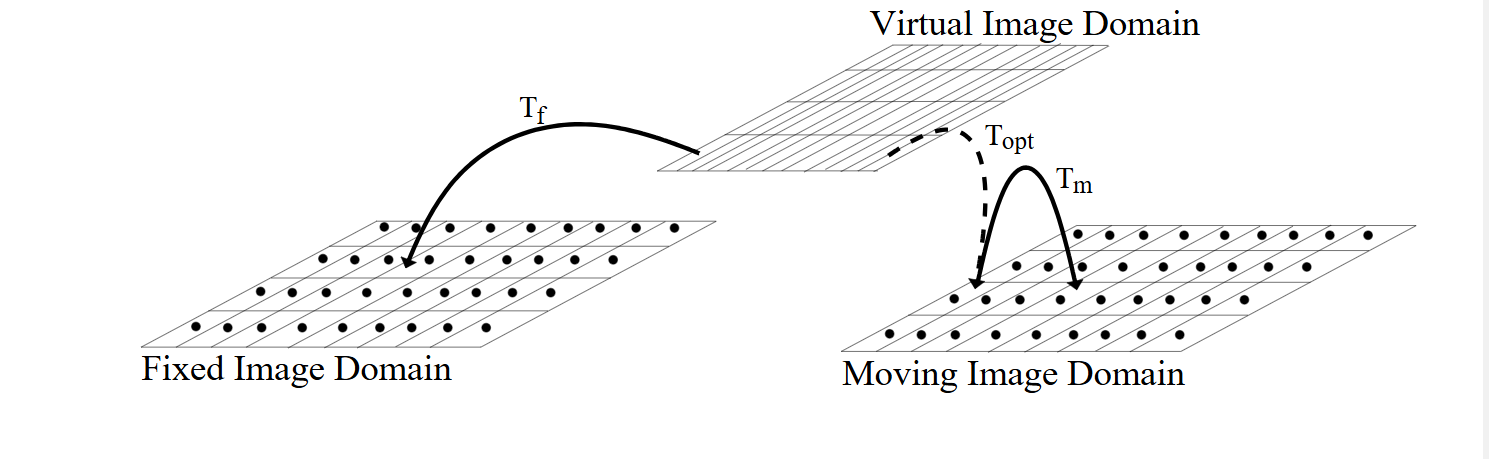

Thus, the ITK v4 registration framework deals with three transformations:
<ul>
<li>
SetInitialTransform, $T_{opt}$ - composed with the moving initial transform, maps points from the virtual image domain to the moving image domain, modified during optimization. 
</li>
<li>
SetFixedInitialTransform $T_f$- maps points from the virtual image domain to the fixed image domain, never modified.
</li>
<li>
SetMovingInitialTransform $T_m$- maps points from the virtual image domain to the moving image domain, never modified.
</li>
</ul>

The transformation that maps points from the fixed to moving image domains is thus: $^M\mathbf{p}  = T_m(T_{opt}(T_f^{-1}(^F\mathbf{p})))$

We now modify the previous example to use $T_{opt}$ and $T_m$.
---



Estimate a 3D rigid transformation between images of different modalities. 

We have made the following choices with respect to initialization and registration component settings:

<ul>

<li>Similarity metric, mutual information (Mattes MI):
<ul>
  <li>Number of histogram bins, 50.</li>
  <li>Sampling strategy, random.</li>
  <li>Sampling percentage, 1%.</li>
</ul>
</li>
<li>Interpolator, sitkLinear.</li>
<li>Optimizer, gradient descent: 
<ul>
  <li>Learning rate, step size along traversal direction in parameter space, 1.0 .</li>
  <li>Number of iterations, maximal number of iterations, 100.</li>
  <li>Convergence minimum value, value used for convergence checking in conjunction with the energy profile of the similarity metric that is estimated in the given window size, 1e-6.</li>
  <li>Convergence window size, number of values of the similarity metric which are used to estimate the energy profile of the similarity metric, 10.</li>
</ul>
</li>
</ul>

We initialize registration by aligning the centers of the two volumes. To qualitatively evaluate the result we use a linked cursor approach, click on one image and the corresponding point is added to the other image.

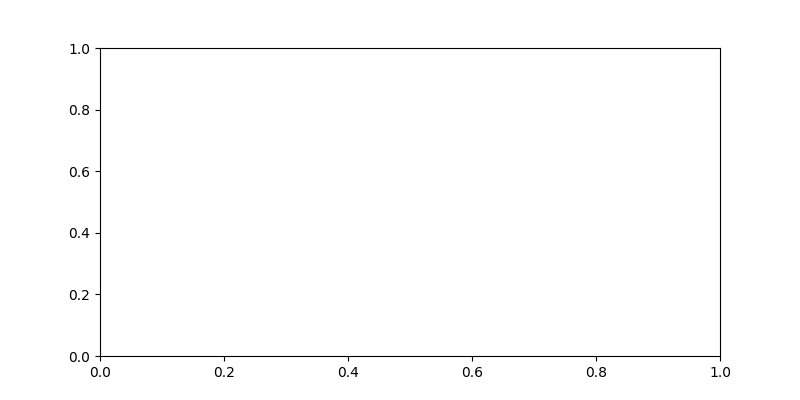

Final metric value: -0.5961687767905441
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [17]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial moving and optimized transforms.
optimized_transform = sitk.Euler3DTransform()
registration_method.SetMovingInitialTransform(initial_transform)
registration_method.SetInitialTransform(optimized_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method)
)

# Need to compose the transformations after registration.
final_transform_v4 = sitk.CompositeTransform(
    [registration_method.Execute(fixed_image, moving_image), initial_transform]
)

# Always check the reason optimization terminated.
print("Final metric value: {0}".format(registration_method.GetMetricValue()))
print(
    "Optimizer's stopping condition, {0}".format(
        registration_method.GetOptimizerStopConditionDescription()
    )
)

Qualitatively evaluate the result using a linked cursor approach (visual evaluation):



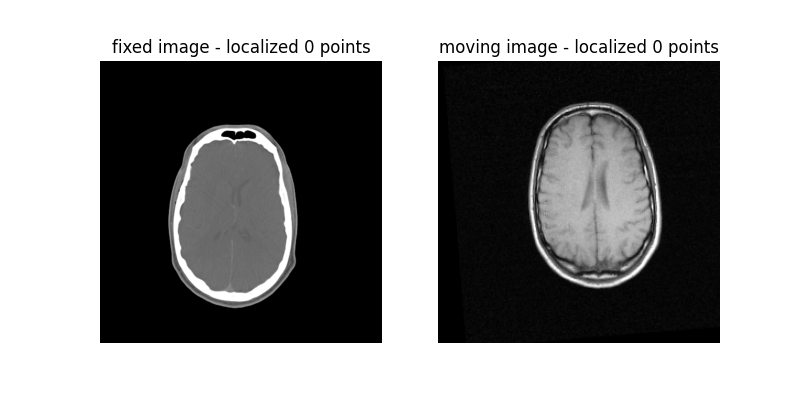

In [18]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform_v4,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

In [19]:
registered_image = sitk.Resample(
    moving_image,             # The image to transform
    fixed_image,              # The reference image for alignment
    final_transform_v4,       # The composite transform
    sitk.sitkLinear,          # Interpolation method
    0.0,                      # Default pixel value for regions outside the image
    moving_image.GetPixelID() # Pixel type remains the same as the moving image
)

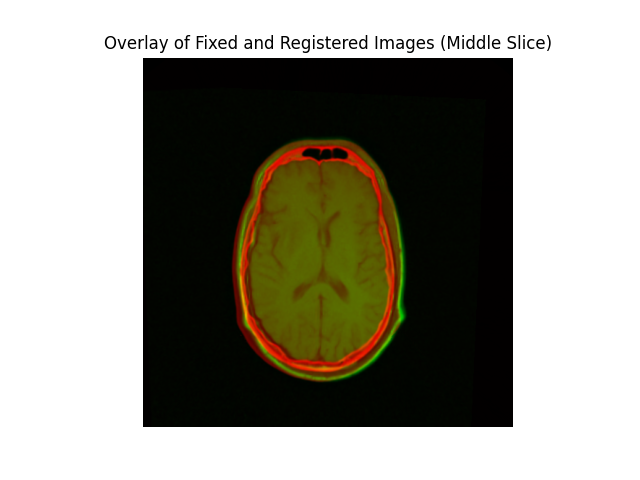

In [21]:
import numpy as np
import matplotlib.pyplot as plt
fixed_array = sitk.GetArrayViewFromImage(fixed_image)
registered_array = sitk.GetArrayViewFromImage(registered_image)

# Normalize images to [0, 1]
fixed_norm = (fixed_array - fixed_array.min()) / (fixed_array.max() - fixed_array.min())
registered_norm = (registered_array - registered_array.min()) / (registered_array.max() - registered_array.min())

middle_slice_index = fixed_norm.shape[0] // 2

# Extract the middle slice for both normalized arrays
fixed_slice = fixed_norm[middle_slice_index, :, :]
registered_slice = registered_norm[middle_slice_index, :, :]

# Create an RGB image for the middle slice
overlay = np.zeros((fixed_slice.shape[0], fixed_slice.shape[1], 3))
overlay[..., 0] = fixed_slice  # Red channel
overlay[..., 1] = registered_slice  # Green channel

# Display the overlay
plt.figure()  # Ensure a fresh plot
plt.imshow(overlay)
plt.title("Overlay of Fixed and Registered Images (Middle Slice)")
plt.axis("off")
plt.show()

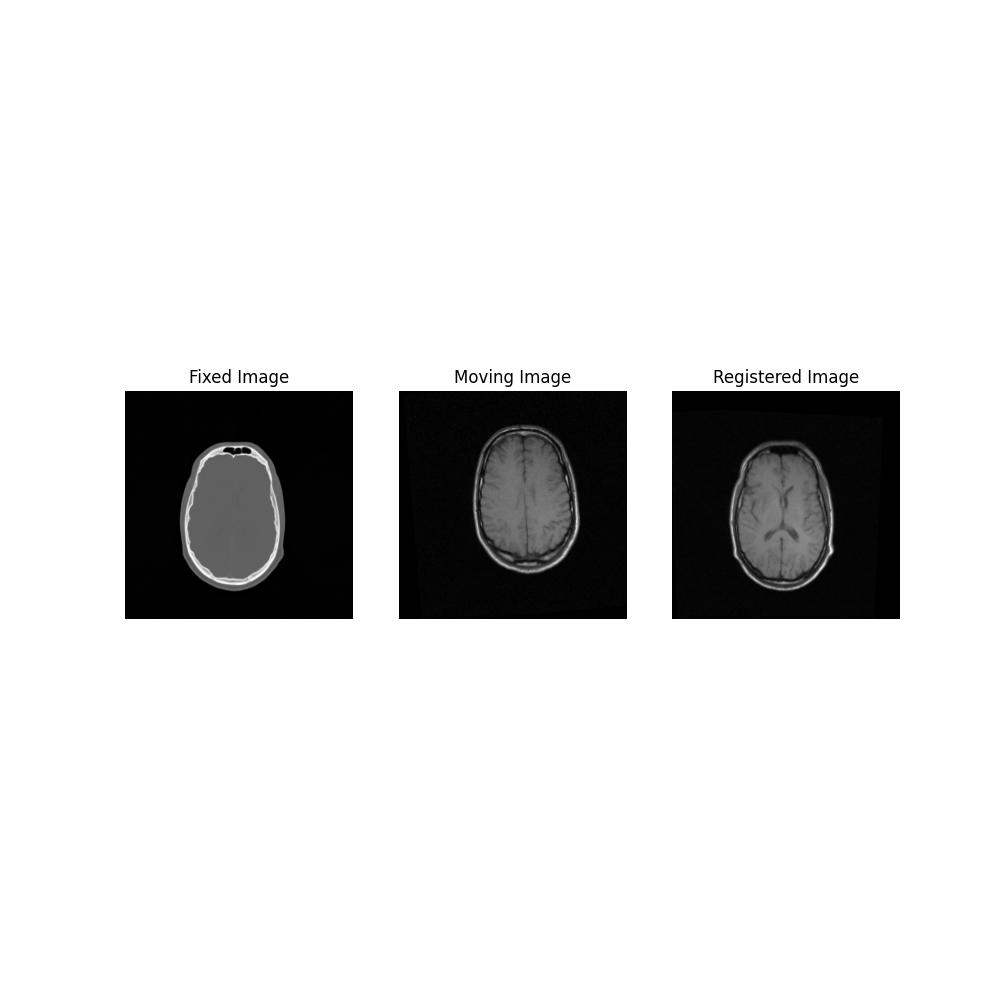

In [22]:
def display_images_middle_slice(images, titles, cmap="gray"):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        # Calculate the middle slice along the z-axis
        middle_slice_index = image.GetSize()[2] // 2
        axes[i].imshow(sitk.GetArrayViewFromImage(image)[middle_slice_index, :, :], cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

display_images_middle_slice(
    [fixed_image, moving_image, registered_image],
    ["Fixed Image", "Moving Image", "Registered Image"]
)


In [23]:
resampled_moving_image = sitk.Resample(
    moving_image,  # The image to transform
    fixed_image,   # Reference image to match
    initial_transform,  # Use the initial transform (or identity)
    sitk.sitkLinear,     # Interpolation method
    0.0,                 # Default pixel value for out-of-bounds regions
    moving_image.GetPixelID()
)

In [24]:
difference_before = sitk.Abs(fixed_image - resampled_moving_image)
difference_after = sitk.Abs(fixed_image - registered_image)


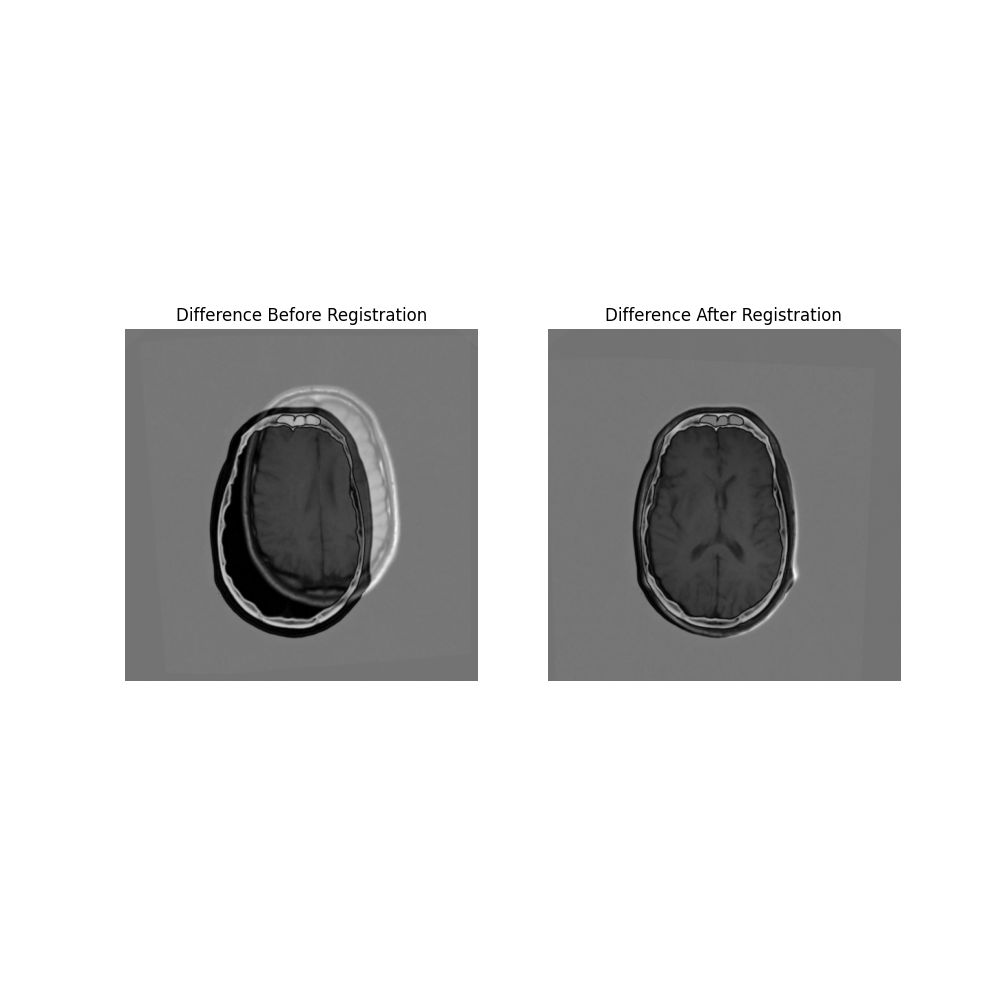

In [25]:
display_images_middle_slice(
    [difference_before, difference_after],
    ["Difference Before Registration", "Difference After Registration"]
)